In [96]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc as pm
import os
import sys
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
sys.path.append(os.path.abspath('../src'))
from data_tools import data_utils

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [90]:
project_dir = project_dir = Path.cwd().parent
trunc_D = 40

data_utils.create_data_split(
    start_year=2013,
    end_year=2020,
    D=trunc_D,
    data_folder_path = project_dir / "data",
    input_filename="DENGSP.csv",
    train_prop=0.7,
    val_prop=0.2,
    test_prop=0.1
)

/Users/jamieharris/Documents/GitHub/Imperial/Dengue-Nowcasting-Thesis/src/data_tools/data_utils.py:19: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf_raw = pd.read_csv(input_data_path, index_col=0)


In [147]:
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)
y_true = train_df.sum(axis=1)
y_true.index = pd.to_datetime(y_true.index)
y_true.index.freq = y_true.index.inferred_freq
y_true

Date_Symptoms
2013-02-10    1394
2013-02-11    1421
2013-02-12    1497
2013-02-13    1666
2013-02-14    1582
              ... 
2018-07-18     113
2018-07-19      96
2018-07-20     112
2018-07-21      78
2018-07-22      83
Freq: D, Length: 1989, dtype: int64

In [80]:
def mask_matrix(matrix, D):
        masked_matrix = matrix.copy()
        nrow, ncol = masked_matrix.shape

        for i in range(nrow):
            for j in range(ncol):
                if i + j > D - 1:
                     masked_matrix[i, j] = False
        return  masked_matrix

def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)



In [ ]:
def proportion_net(Z_data, n_hidden, output_dim):
    T,D = Z_data.shape
    # Prior
    W1_net = pm.Normal("W1_net", mu=0, sigma=1, shape=(D, n_hidden))
    b1_net = pm.Normal("b1_net", mu=0, sigma=1, shape=(n_hidden,))

    W2_net = pm.Normal("W2_net", mu=0, sigma=1, shape=(n_hidden, n_hidden))
    b2_net = pm.Normal("b2_net", mu=0, sigma=1, shape=(n_hidden,))
    
    W3_net = pm.Normal("W3_net", mu=0, sigma=1, shape=(n_hidden, output_dim))
    b3_net = pm.Normal("b3_net", mu=0, sigma=1, shape=(output_dim,))
    
    # Forward pass
    h1 = pm.math.tanh(pm.math.dot(Z_data, W1_net) + b1_net)  # shape (T, n_hidden)
    h2 = pm.math.tanh(pm.math.dot(h1, W2_net) + b2_net)
    p_raw = pm.math.dot(h2, W3_net) + b3_net  # shape (T, D)
    
    return p_raw

def get_nowcast(Z_data, t_scaled, fourier_features, model_D, mask):

    with pm.Model() as dir_model:
        t_shared = pm.Data("t", t_scaled)
        Z_shared = pm.Data("Z_data", Z_data)

        # Linear trend parameters
        # Linear trend parameters
        b0 = pm.Normal("b0", mu=0, sigma=0.5)   # intercept
        b1 = pm.Normal("b1", mu=0, sigma=0.5)
        mean_func = pm.gp.mean.Linear(coeffs=b1, intercept=b0)


        ell = pm.Gamma("ell", alpha=10, beta=1)   # length scale
        eta = pm.HalfNormal("eta", sigma=2)      # amplitude
        cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

        gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov)

        f = gp.prior("f", X=t_shared[:, None])

        fourier_shared = create_fourier_features(t_shared, n=10, p=3.5)
        beta_fourier = pm.Normal("beta_fourier", 0, 0.1, shape=fourier_shared.shape[1])
        seasonality = pm.Deterministic(
            "seasonality", pm.math.dot(fourier_shared, beta_fourier)
        )
        
        log_lam = f + seasonality
        lam = pm.Deterministic("lam", pm.math.exp(log_lam))

        
        p = pm.Dirichlet()

        # Create matrix of lam[t,:] * p[t,d]
        mu = lam[:, None] * p

        alpha = pm.HalfNormal("alpha", sigma=2)  # overdispersion param
        # y_hat = pm.NegativeBinomial("y_hat", mu=lam, alpha=alpha)

        
        z = pm.NegativeBinomial("z", mu[mask], alpha, observed=Z_data[mask])

        idata = pm.sample(nuts_sampler="numpyro", progressbar=False)
            
    lam_post_samples = az.extract(idata, group="posterior", num_samples=1000)["lam"]
    med_train = np.percentile(lam_post_samples, 50, axis=1)
    
    return med_train



There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


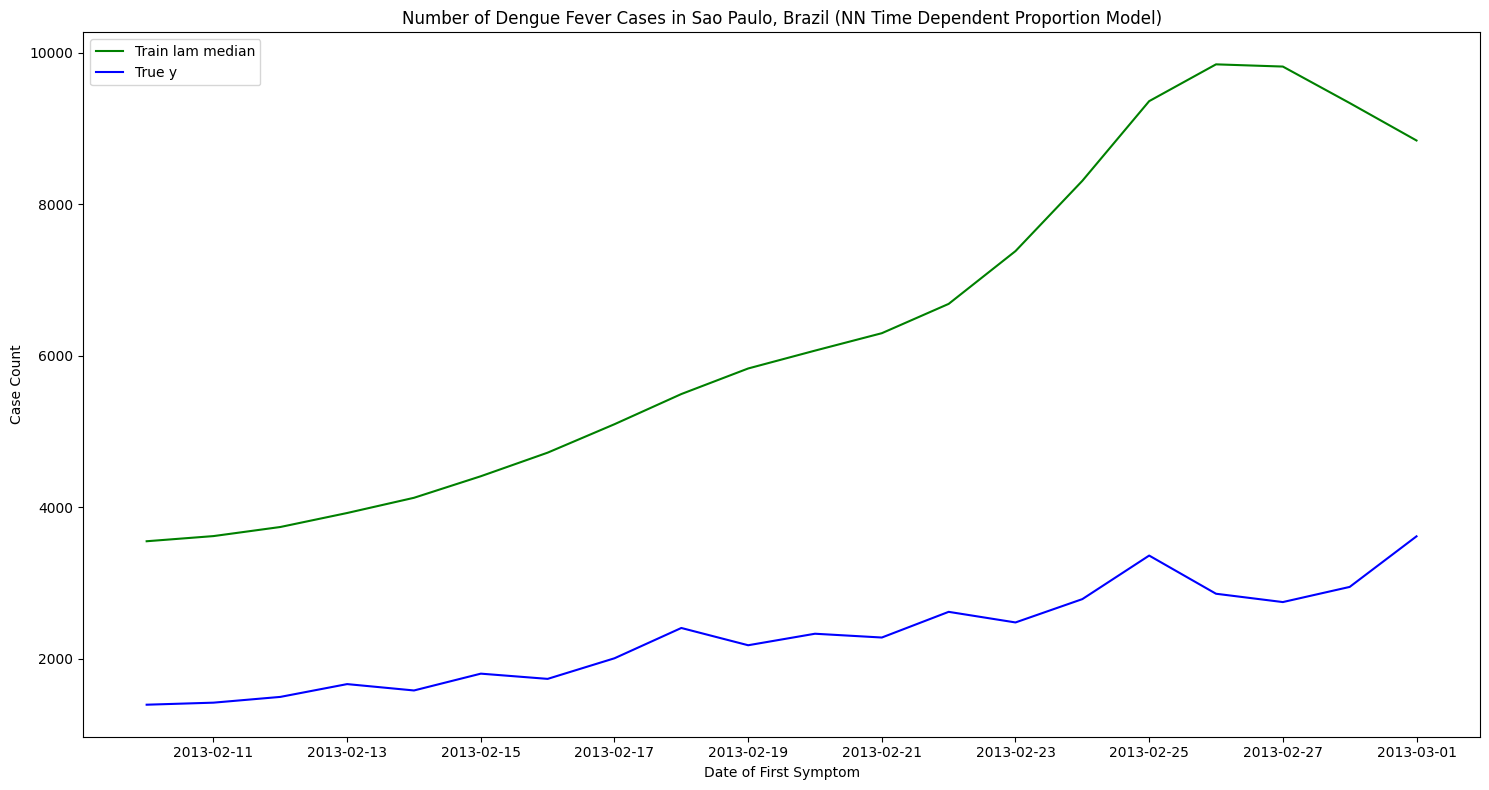

In [ ]:
M=0
model_D=20
n_points = 3
Z_model_data = train_df.copy().iloc[:, 0:model_D]

# Create normalised time points
t = np.arange(0, M + model_D)
t_min = t.min()
t_max= t.max()
t_scaled = (t - t_min) / (t_max - t_min)

features = create_fourier_features(t_scaled, n=20, p=7)
nowcasts = []

for start_index in range(0,n_points):
    Z_data = Z_model_data.values[start_index: start_index + M + model_D]
    y_data = y_true.iloc[start_index: start_index + M + model_D]
    mask = np.ones_like(Z_data, dtype=bool)
    mask[-model_D:] = mask_matrix(np.array(mask[-model_D:]), model_D)
    Z_data[~mask] = 0

    med = get_nowcast(Z_data, t_scaled, features, model_D, mask)
    # Plot stacked bars
    plt.figure(figsize=(15, 8))

    # Plot CI for training data
    plt.plot(y_data.index,  med, color='green', label="Train lam median")
    plt.plot(y_data.index,  y_data, color='blue', label="True y")


    plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil (NN Time Dependent Proportion Model)")
    plt.xlabel("Date of First Symptom")
    plt.ylabel("Case Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

